In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Subset
import random
import matplotlib.pyplot as plt
import numpy as np

# Reproducibility
torch.manual_seed(0)
random.seed(0)

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='data', train=False, transform=transform)

train_subset = Subset(train_data, random.sample(range(len(train_data)), 10_000))
test_subset = Subset(test_data, random.sample(range(len(test_data)), 2_000))

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64)

# Modified model with dropout as parameter
class DropoutNet(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size, dropout_rate):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden1_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden2_size, hidden3_size),
            nn.ReLU(),
            nn.Linear(hidden3_size, output_size)
        )

    def forward(self, x):
        return self.net(x)

# Training loop with accuracy tracking
def train_and_track(model, train_loader, test_loader, loss_fn, optimizer, epochs=5):
    train_accs = []
    test_accs = []

    for _ in range(epochs):
        model.train()
        for X, y in train_loader:
            pred = model(X)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluation at end of epoch
        train_accs.append(evaluate_model(model, train_loader))
        test_accs.append(evaluate_model(model, test_loader))

    return train_accs, test_accs

def train_and_track_training_acc_frequent(model, train_loader, loss_fn, optimizer, test_loader, log_interval=200, max_steps=2000):
    model.train()
    step = 0
    acc_steps = []
    acc_values = []

    while step < max_steps:
        for X, y in train_loader:
            pred = model(X)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % log_interval == 0:
                acc = evaluate_model(model, test_loader)
                acc_steps.append(step)
                acc_values.append(acc)

            step += 1
            if step >= max_steps:
                break

    return acc_steps, acc_values


# Evaluation (same as before)
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            pred = model(X)
            predicted = pred.argmax(dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    return correct / total

# Hyperparameter grid
learning_rates = [0.001, 0.005, 0.01, 0.05]
dropout_rates = [0.0, 0.2, 0.4, 0.6]

# Fixed model size
input_size = 28 * 28
hidden1, hidden2, hidden3 = 256, 64, 32
output_size = 10
epochs = 10

results = {}
for lr in learning_rates:
    for do in dropout_rates:
        model = DropoutNet(input_size, hidden1, hidden2, hidden3, output_size, dropout_rate=do)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()

        print(f"Training model with LR={lr}, Dropout={do}")
        steps, accs = train_and_track_training_acc_frequent(
            model, train_loader, loss_fn, optimizer, test_loader, log_interval=20, max_steps=2000
        )
        print(f"(accs): {accs}")
        results[(lr, do)] = (steps, accs)





Training model with LR=0.001, Dropout=0.0
(accs): [0.103, 0.54, 0.743, 0.7965, 0.8505, 0.8665, 0.8865, 0.884, 0.8845, 0.898, 0.893, 0.9095, 0.9185, 0.914, 0.906, 0.921, 0.9205, 0.927, 0.9315, 0.9285, 0.9375, 0.9385, 0.9345, 0.917, 0.937, 0.933, 0.939, 0.936, 0.942, 0.936, 0.944, 0.9425, 0.9445, 0.944, 0.9445, 0.946, 0.947, 0.948, 0.9475, 0.9455, 0.947, 0.95, 0.9505, 0.9495, 0.9515, 0.9495, 0.942, 0.9475, 0.9475, 0.952, 0.9515, 0.953, 0.941, 0.95, 0.9485, 0.9475, 0.9465, 0.9535, 0.9535, 0.954, 0.9525, 0.955, 0.952, 0.9505, 0.956, 0.948, 0.9535, 0.9525, 0.949, 0.955, 0.9545, 0.9465, 0.955, 0.9575, 0.9545, 0.955, 0.9565, 0.958, 0.9545, 0.9455, 0.953, 0.9515, 0.959, 0.9565, 0.9555, 0.953, 0.9535, 0.9435, 0.9575, 0.9585, 0.957, 0.962, 0.9565, 0.955, 0.9595, 0.954, 0.9575, 0.9565, 0.9545, 0.9555]
Training model with LR=0.001, Dropout=0.2
(accs): [0.145, 0.4695, 0.677, 0.8125, 0.851, 0.8715, 0.8825, 0.8795, 0.8885, 0.906, 0.913, 0.911, 0.916, 0.8975, 0.898, 0.912, 0.9015, 0.9145, 0.9295, 0.92

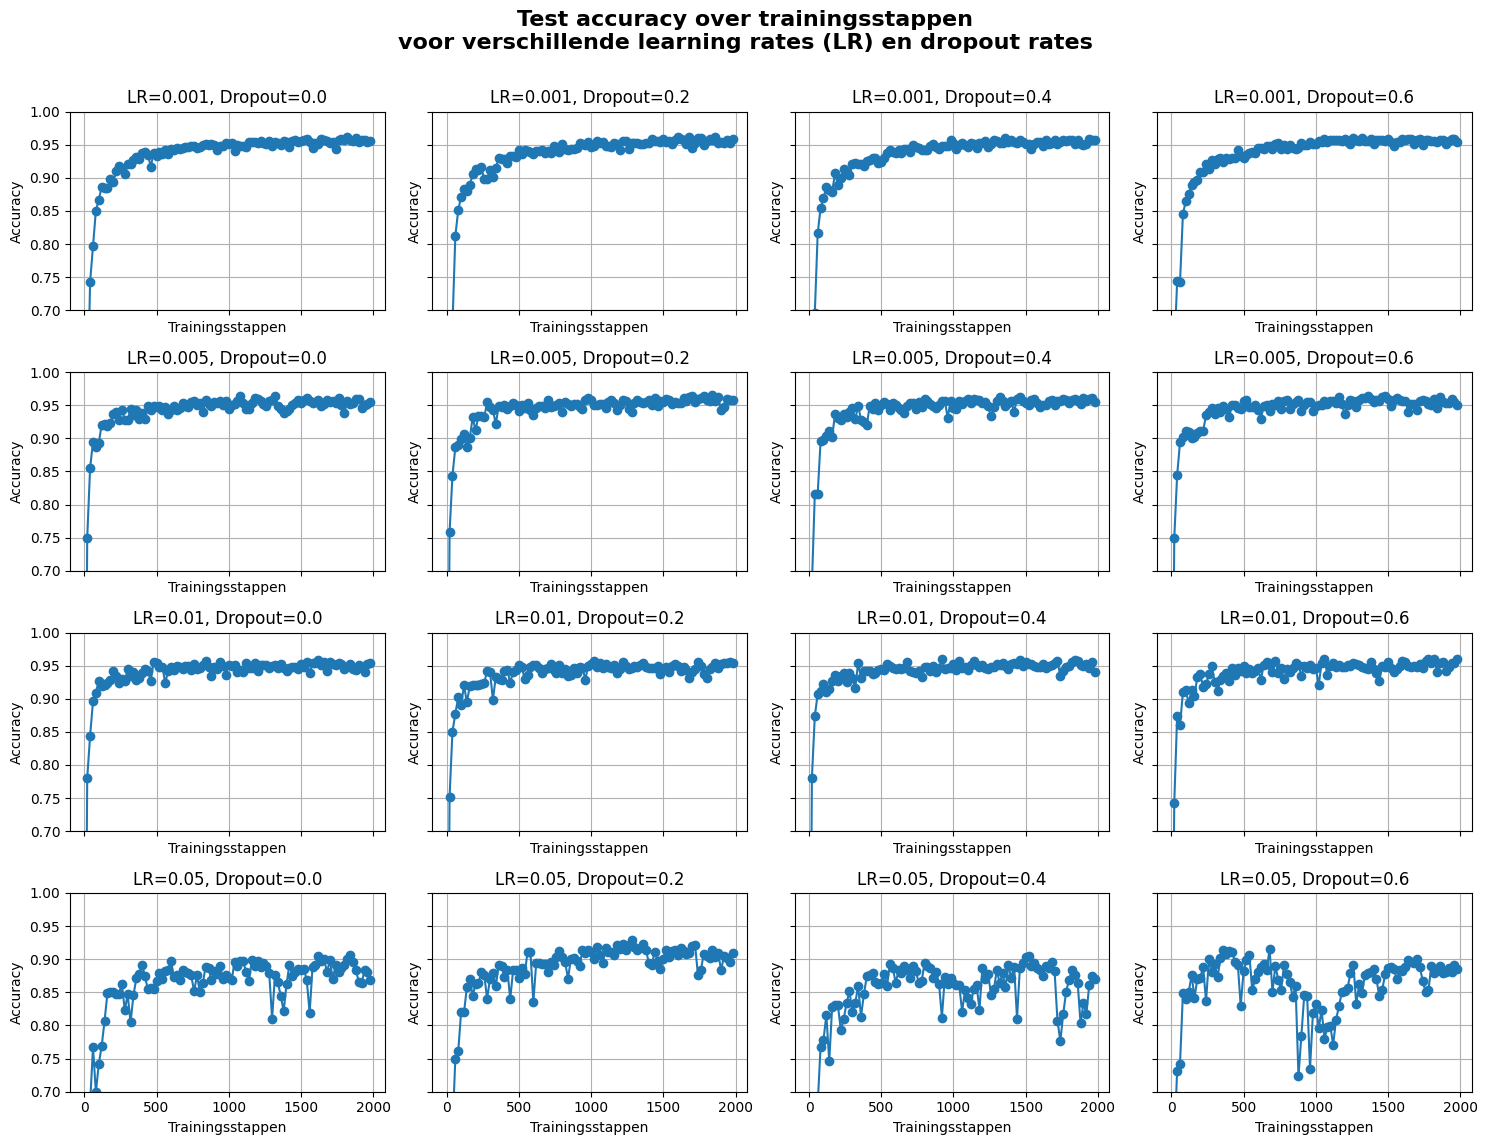

In [19]:
# Plotting results in 3x3 grid
fig, axes = plt.subplots(len(learning_rates), len(dropout_rates), figsize=(15, 12), sharex=True, sharey=True)

for i, lr in enumerate(learning_rates):
    for j, do in enumerate(dropout_rates):
        ax = axes[i, j]
        steps, accs = results[(lr, do)]
        ax.plot(steps, accs, marker='o')
        ax.set_title(f"LR={lr}, Dropout={do}")
        ax.set_xlabel("Trainingsstappen")
        ax.set_ylabel("Accuracy")
        ax.set_ylim(0.7, 1.0)
        ax.grid(True)

plt.suptitle("Test accuracy over trainingsstappen\nvoor verschillende learning rates (LR) en dropout rates", fontsize=16, fontweight='bold')
# plt.suptitle("Test Accuracy over Epochs\nfor different Learning Rates and Dropout Rates", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.975])
plt.show()